In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

import ternary

In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfgs = [c for c in configs if 'mnist_multinomial' in c['name'] 
        and c['config']['dataset']['n_sets'] == 10000 and c['config']['dataset']['alpha'] in [1,4,16,64]]
alphas = [c['config']['dataset']['alpha'] for c in cfgs]
print(alphas)

[64, 16, 4, 1]


In [3]:
def simplex_grid(dim, points_per_dim):
    lin = np.linspace(0, 1, points_per_dim)
    grid = np.array(list(product(*([lin] * dim))))
    grid = grid[np.isclose(grid.sum(axis=1), 1)]  # keep only rows that sum to 1
    return grid

def prepare_dataset(dataset_cfg, points_per_dim=10, set_size=100):
    dataset = hydra.utils.instantiate(dataset_cfg)
    if points_per_dim != None:
        probs = simplex_grid(dataset_cfg['n_classes'], points_per_dim)
        dataset.custom_probs = probs
        dataset.set_size = set_size
        dataset.n_sets = len(probs)
        dataset.data, dataset.metadata, dataset.prob = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_encoder(cfg, path, device):
    enc = hydra.utils.instantiate(cfg)
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    enc.eval()
    enc.to(device)
    return enc

def batched_dists(dataset, encoder, batch_size=8, device='cuda'):

    with torch.no_grad():
        fr = torch.tensor(dataset.fisher_rao_distance(np.array(dataset.prob)))
        x_all = torch.tensor(dataset.data, dtype=torch.float32)

        zs = []
        for i in range(0, x_all.size(0), batch_size):
            x_chunk = x_all[i:i+batch_size].to(device)
            z_chunk = encoder(x_chunk).cpu()  # offload!
            zs.append(z_chunk)
        z = torch.cat(zs, dim=0).to(device)  # full z back on gpu :)

    return fr, torch.cdist(z, z, p=2)


def plot_ternary(ax, dists, dataset, title=None, scale=99):

    prob_tuples = [tuple(np.round(s * scale)) for s in dataset.custom_probs]
    anchor_idx = prob_tuples.index((scale//3, scale//3, scale//3))
    colors = dists[anchor_idx]
    simplex_d = {prob_tuples[i]: colors[i] for i in range(len(prob_tuples))}

    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax.heatmap(simplex_d, style="h")
    tax.boundary()
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    if title:
        tax.set_title(title)

    tax.scatter([prob_tuples[anchor_idx]], marker='*', color='pink', s=100, zorder=10)

processing cfg 1/4


/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/mnist.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.mnist.targets)
/tmp/ipykernel_2476628/3722023789.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_all = torch.tensor(dataset.data, dtype=torch.float32)
/home/gokulg/.conda/envs/metaMI/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


processing cfg 2/4
processing cfg 3/4
processing cfg 4/4


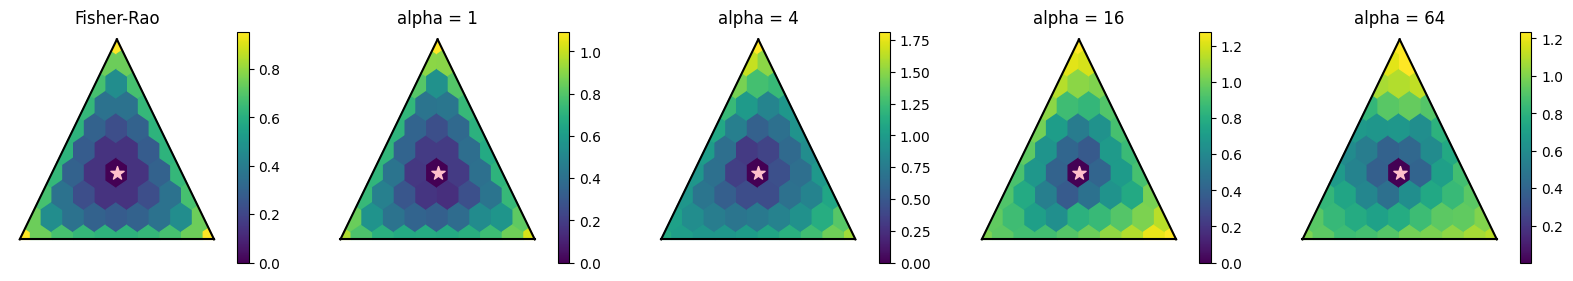

In [4]:
points_per_dim = 10
set_size = 1000

fig, axs = plt.subplots(1, len(cfgs)+1, figsize=(4 * (len(cfgs)+1), 3))

for i, cfg in enumerate(cfgs):
    print(f'processing cfg {i+1}/{len(cfgs)}')

    encoder = load_encoder(cfg['config']['encoder'], cfg['dir'], device)
    dataset_cfg = cfg['config']['dataset']
    dataset = prepare_dataset(dataset_cfg, points_per_dim, set_size)
    fr, dists = batched_dists(dataset, encoder, device=device, batch_size=1)
    dists = dists.cpu().numpy()
    alpha_index = sorted(alphas).index(alphas[i])

    plot_ternary(axs[alpha_index+1], dists, dataset, title=f"alpha = {alphas[i]}", scale=9)

    if i == 0:
        plot_ternary(axs[0], fr, dataset, title='Fisher-Rao', scale=9)

processing cfg 1/4


/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/mnist.py:238: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))
/tmp/ipykernel_2476628/3722023789.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_all = torch.tensor(dataset.data, dtype=torch.float32)


processing cfg 2/4
processing cfg 3/4
processing cfg 4/4


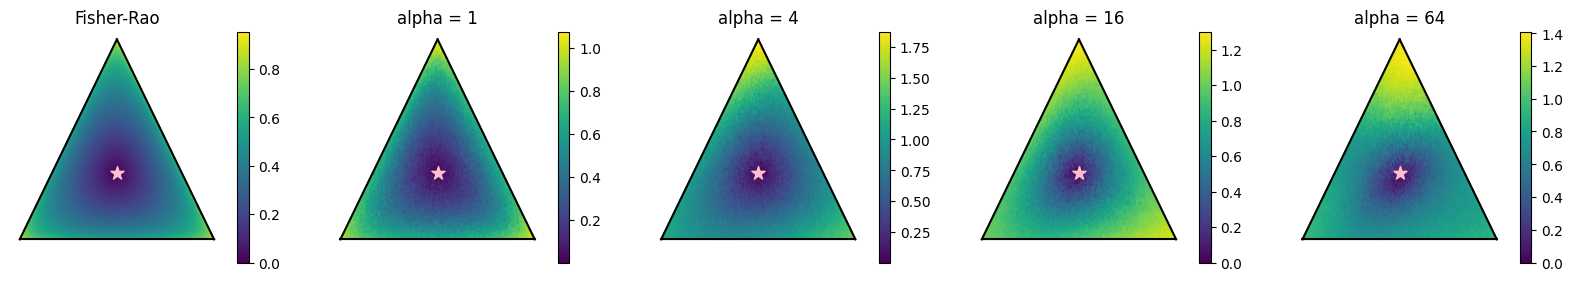

In [5]:
points_per_dim = 100
set_size = 1000

fig, axs = plt.subplots(1, len(cfgs)+1, figsize=(4 * (len(cfgs)+1), 3))

for i, cfg in enumerate(cfgs):
    print(f'processing cfg {i+1}/{len(cfgs)}')

    encoder = load_encoder(cfg['config']['encoder'], cfg['dir'], device)
    dataset_cfg = cfg['config']['dataset']
    dataset = prepare_dataset(dataset_cfg, points_per_dim, set_size)
    fr, dists = batched_dists(dataset, encoder, device=device, batch_size=1)
    dists = dists.cpu().numpy()
    alpha_index = sorted(alphas).index(alphas[i])

    plot_ternary(axs[alpha_index+1], dists, dataset, 
                 title=f"alpha = {alphas[i]}", scale=99)

    if i == 0:
        plot_ternary(axs[0], fr, dataset, title='Fisher-Rao')

processing cfg 1/4


/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/mnist.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.mnist.targets)
/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/mnist.py:238: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))
/tmp/ipykernel_2476628/3722023789.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_all = torch.tensor(dataset.data, dtype=torch.float32)


processing cfg 2/4
processing cfg 3/4
processing cfg 4/4


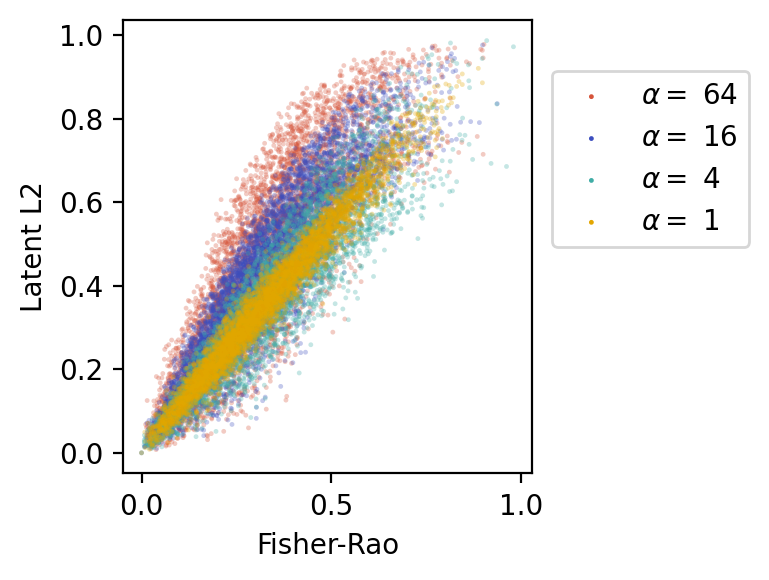

In [8]:
points_per_dim = 100
set_size=1000

pretty_palette = [#'#edb1a3',
          '#d6543a',
          #'#c4bae2',
          '#3c4ebf',
          '#40ada6',
          '#e3a600']


fig, ax = plt.subplots(1, 1, figsize=(4,3), dpi=200)
for i, cfg in enumerate(cfgs):
    print(f'processing cfg {i+1}/{len(cfgs)}')

    encoder = load_encoder(cfg['config']['encoder'], cfg['dir'], device)
    dataset_cfg = cfg['config']['dataset']
    dataset = prepare_dataset(dataset_cfg, points_per_dim, set_size)
    fr, dists = batched_dists(dataset, encoder, device=device, batch_size=1)
    dists = dists.cpu().numpy()
    fr = np.nan_to_num(fr)

    norm_fr = fr.flatten()/fr.flatten().max()
    norm_dists = dists.flatten()/dists.flatten().max()

    inds = np.arange(len(norm_fr))
    np.random.shuffle(inds)

    ax.scatter(norm_fr[inds[:5000]], norm_dists[inds[:5000]], 
            s=3, alpha=0.3, label = r"$\alpha=$ " + str(alphas[i]), c=pretty_palette[i], edgecolor='none')


ax.set_ylabel('Latent L2')
ax.set_xlabel('Fisher-Rao')
leg = plt.legend(loc=(1.05, 0.5))
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.tight_layout()
plt.show()